<a href="https://colab.research.google.com/github/louhongyu/-botpress/blob/master/%E4%BC%98%E5%8C%96xgboost_CINV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 5 folds for each of 4374 candidates, totalling 21870 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:37:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found by GridSearchCV:
{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 0.9}
Classification Report with Adjusted Threshold (XGBoost):
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        76
           1       0.82      0.93      0.87        60

    accuracy                           0.88       136
   macro avg       0.88      0.89      0.88       136
weighted avg       0.89      0.88      0.88       136



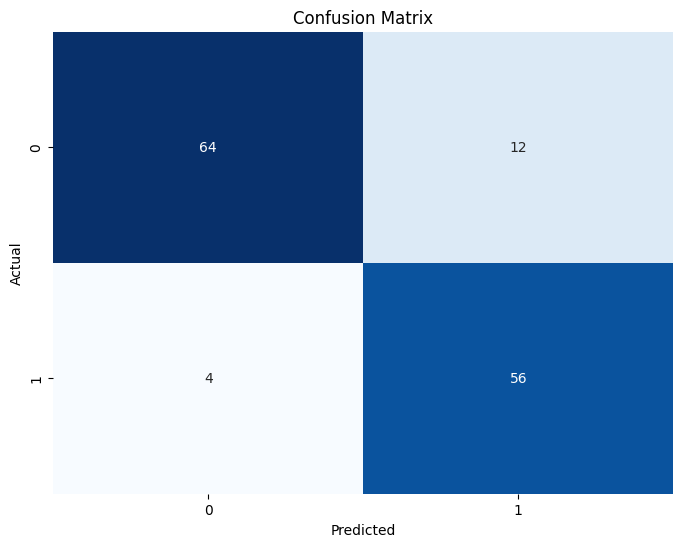

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


# 1.加载数据
file_path = '/content/0726邓军数据.xlsx'
clean_sheet_data = pd.read_excel(file_path, sheet_name='clean')

# 2. 数据标准化
continuous_columns = ['年龄', '身高', '体重', '体表面积', 'KPS评分', '睡眠时间', '其他症状数量', '伴随症状数量', '疗程数', '化疗天数', '儿童致吐风险']
scaler = StandardScaler()
clean_sheet_data_scaled = clean_sheet_data.copy()
clean_sheet_data_scaled[continuous_columns] = scaler.fit_transform(clean_sheet_data[continuous_columns])

# 3. 特征选择（使用随机森林）
X = clean_sheet_data_scaled.drop(columns=['预期性二分类', '急性二分类', '延迟性二分类', '总二分类']).values
y = clean_sheet_data['预期性二分类'].values

# 4. 使用SMOTETomek进行数据重采样
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# 5. 数据分割
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 6. 定义XGBoost模型和参数网格
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'scale_pos_weight': [1, len(y_train) / sum(y_train)]
}

# 7. 使用GridSearchCV进行超参数优化
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 8. 打印最佳参数
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# 9. 使用最佳参数训练模型
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# 10. 调整阈值
threshold = 0.3  # 根据需要调整阈值
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# 11. 评估
print('Classification Report with Adjusted Threshold (XGBoost):')
print(classification_report(y_test, y_pred_adjusted, zero_division=1))

# 12. 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
